# Solveur par transport optimal

L'objectif de ce cahier est de tester un solveur par transport optimal, notamment à l'aide d'un signal-jouet.

 ## Implémentation du solveur

On commence par importer les modules nécessaires : 
    - **ot** pour le transport optimal;
    - **scipy.optimize** pour le simplexe;
    - **scipy.signal** pour les spectrogrammes;
    - **numpy** pour la manipulation de tableaux;
    - **matplotlib.pyplot** pour l'affichage de courbes.

In [1]:
import ot
import scipy.optimize, scipy.signal
import numpy as np
import matplotlib.pyplot as plt

L'objectif ici est d'obtenir une PLCA à l'aide d'un dictionnaire **W** et d'un vecteur **v**

On calcule pour cela une matrice de coût **C**. Nous implémentons, dans un premier temps, une matrice en fréquence, à partir du tableau **F** des fréquences du dictionnaire.

In [2]:
def frequential_cost_matrix(F):
    M = F.shape[0]
    C = np.zeros((M,M))
    for i in range(M):
        for j in range(M):
            C[i,j] = (F[i]-F[j])**2
    return C

On cherche alors **T** et **v** positives de sorte à minimiser **<T,C>F**, avec **T\*1 = v** et **tT\*1 = W\*h**, en déroulant les matrices en vecteurs colonnes, on se ramène à un problème d'optimisation linéaire. Nous résolvons donc ce problème avec l'algorithme du simplexe.

On calcule pour cela sa représentation canonique, sous forme de matrice:
  - minimiser <th,ch>F avec (th)_i = (T)_i//M,(i mod M) pour i<M^2, h_i sinon , et (ch)_i = (C)_i//M,(i mod M), pour i<M^2, h_i sinon;
  - pour tout i<= M, somme_j (th)_i*M+j = v_i;
  - pour tout j, somme_i (th)_i*M+j = (Wh)_j = somme_k (W)_jk \* h_k = somme_k (W)_jk \* (th)_M^2+k;
  - th >= 0.

In [57]:
def simplex_OT_canonical_matrices(v, W, C):
    M = v.shape[0]
    K = W.shape[1]
    # Coefficients for minimization
    c = np.zeros((M**2+ K,))
    #Constraints matrix and vertice
    A = np.zeros((2*M,M**2+ K))
    b = np.zeros((2*M,))
    
    # c is unfolding C and letting zeros after
    c[:M**2] =  [C[i//M, i%M] for i in range(M**2)]
    
    # Writing first constraints set
    for i in range(M):
        for j in range(M):
            A[i, i*M+j] = 1
        b[i] = v[i] 
    
    # Writing second constraints set
    for j in range(M):
        for i in range(M):
            A[M + j, i*M+j] = 1
        for k in range(K):
            A[M + j, M**2 +k] = -W[j,k]
    
    # Returning matrices
    return c, A, b

def simplex_algorithm(c, A, b):
    #result = scipy.optimize.linprog(c, method="simplex", options={'A':A, 'b':b})
    result = scipy.optimize.linprog(c, A_eq=A, b_eq=b,bounds=(0, None))
    if not result.success:
        print("Failure: ", result.message)
    print("Simplex iterations:", result.nit)
    return result.x

Nous pouvons donc ensuite isoler **h** à partir du retour, en prenant les dernières valeurs. Il nous reste donc à définir la fonction déterminant **h** à partir de **v**, **C**, et **W**.

In [4]:
def compute_NMF(v,C,W):
    c, A, b = simplex_OT_canonical_matrices(v, W, C)
    th = simplex_algorithm(c, A, b)
    K = W.shape[1]
    h = th[-K:]
    return h

Nous pouvons donc définir notre solveur.

## Tests

Il nous reste donc à effectuer des tests pour voir si tout fonctionne bien.

### Test du simplexe

Testons tout d'abord notre algorithme du simplexe, avec l'[exemple](https://en.wikipedia.org/wiki/Simplex_algorithm#Example) suivant.

In [5]:
c = np.array([-2,-3,-4,0,0])
A = np.array([[3,2,1,1,0],
              [2,5,3,0,1]])
b = np.array([10,15])

print(simplex_algorithm(c,A,b))

[1.23058104e-11 3.23362187e-12 5.00000000e+00 5.00000000e+00
 1.44464717e-11]


## Test de la forme canonique

In [6]:
v = np.array([0.6,0.4])
W = np.array([[1, 0.5],
              [0, 0.5]])
C = np.array([[0,1],
              [1,0]])

c,A,b = simplex_OT_canonical_matrices(v, W, C)
print(c)
print(A)
print(b)

h = simplex_algorithm(c,A,b)[-2:]

print("h =",h)
print("Wh =",np.dot(W,h))

print(np.sum(h))

[0. 1. 1. 0. 0. 0.]
[[ 1.   1.   0.   0.   0.   0. ]
 [ 0.   0.   1.   1.   0.   0. ]
 [ 1.   0.   1.   0.  -1.  -0.5]
 [ 0.   1.   0.   1.  -0.  -0.5]]
[0.6 0.4 0.  0. ]
h = [0.2 0.8]
Wh = [0.6 0.4]
1.0000000019705162


## Test avec un signal-jouet

Nous générons d'abord le signal-jouet, composé de trois sinusoïdes de fréquences différentes.

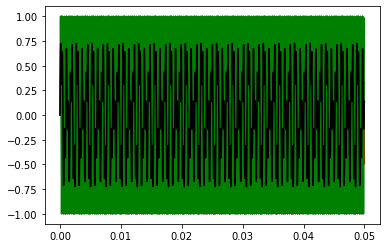

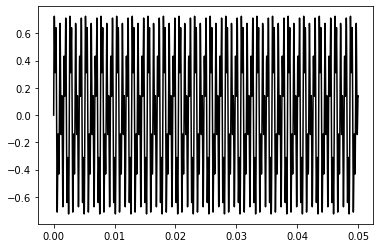

In [7]:
fs = 10e4
N = 5000
T = np.arange(N) / fs

f1 = 781.25
f2 = 1171.875
f3 = 3125
coefficients = [1/6,3/6,2/6]

s1 = np.sin(2*np.pi*f1 * T)
s2 = np.sin(2*np.pi*f2 * T)
s3 = np.sin(2*np.pi*f3 * T)

st = (  coefficients[0] * s1 +
        coefficients[1] * s2 + 
        coefficients[2] * s3)

plt.plot(T, s1, color = 'blue')
plt.plot(T, s2,color = 'red')
plt.plot(T, s3, color = 'green')
plt.plot(T, st, color = 'black')
plt.show()
plt.plot(T, st, color = 'black')
plt.show()

Nous obtenons ensuite les spectres de ces signaux.

[    0.      390.625   781.25   1171.875  1562.5    1953.125  2343.75
  2734.375  3125.     3515.625  3906.25   4296.875  4687.5    5078.125
  5468.75   5859.375  6250.     6640.625  7031.25   7421.875  7812.5
  8203.125  8593.75   8984.375  9375.     9765.625 10156.25  10546.875
 10937.5   11328.125 11718.75  12109.375 12500.    12890.625 13281.25
 13671.875 14062.5   14453.125 14843.75  15234.375 15625.    16015.625
 16406.25  16796.875 17187.5   17578.125 17968.75  18359.375 18750.
 19140.625 19531.25  19921.875 20312.5   20703.125 21093.75  21484.375
 21875.    22265.625 22656.25  23046.875 23437.5   23828.125 24218.75
 24609.375 25000.    25390.625 25781.25  26171.875 26562.5   26953.125
 27343.75  27734.375 28125.    28515.625 28906.25  29296.875 29687.5
 30078.125 30468.75  30859.375 31250.    31640.625 32031.25  32421.875
 32812.5   33203.125 33593.75  33984.375 34375.    34765.625 35156.25
 35546.875 35937.5   36328.125 36718.75  37109.375 37500.    37890.625
 38281.25  38671.

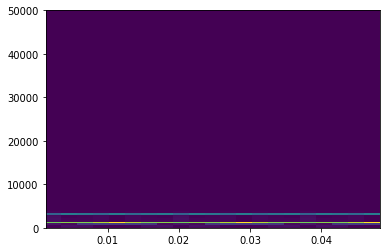

In [8]:
f,t,St = scipy.signal.spectrogram(st, fs=fs )
f1,t1,S1 = scipy.signal.spectrogram(s1, fs = fs)
f2,t2,S2 = scipy.signal.spectrogram(s2, fs = fs)
f3,t3,S3 = scipy.signal.spectrogram(s3, fs = fs)
print(f)
plt.pcolormesh(t,f,St)
plt.show()

On en extrait ensuite une trame isolée. que l'on normalise.

In [9]:
v= St[:, t.shape[0]//4]
v/=np.sum(v)
v1 = S1[:, t.shape[0]//4]
v1/=np.sum(v1)
v2 = S2[:, t.shape[0]//4]
v2/=np.sum(v2)
v3 = S3[:, t.shape[0]//4]
v3/=np.sum(v3)

print(v1)
print(v2)
print(v3)

[2.88202520e-02 5.42055983e-02 8.45000000e-01 3.27910330e-02
 2.07505734e-02 1.11995000e-02 5.00000000e-03 1.74626931e-03
 4.23481916e-04 4.97757431e-05 5.21098123e-31 6.04251242e-06
 5.22824425e-06 1.24097025e-06 1.47183721e-31 3.42557462e-07
 3.88894172e-07 1.14954200e-07 6.61998758e-32 4.43989852e-08
 5.75342410e-08 1.90823701e-08 1.20639681e-31 8.92344319e-09
 1.25319868e-08 4.46872837e-09 8.69733314e-33 2.36877704e-09
 3.51354710e-09 1.31738386e-09 7.52855166e-32 7.63412513e-10
 1.17827928e-09 4.58447505e-10 4.43715044e-32 2.84042021e-10
 4.51898978e-10 1.80909781e-10 1.22274269e-32 1.18091383e-10
 1.92432877e-10 7.88044651e-11 9.26284930e-33 5.36447107e-11
 8.91317444e-11 3.71833761e-11 3.21167827e-33 2.62017193e-11
 4.42431297e-11 1.87445434e-11 6.39439385e-33 1.35977150e-11
 2.32763474e-11 9.99193979e-12 2.64620228e-32 7.43068187e-12
 1.28701943e-11 5.58794786e-12 1.79530170e-30 4.24631325e-12
 7.43081400e-12 3.25863060e-12 1.66104720e-30 2.52395182e-12
 4.45733502e-12 1.972140

Nous générons ensuite le dictionnaire associé.

(129, 3)


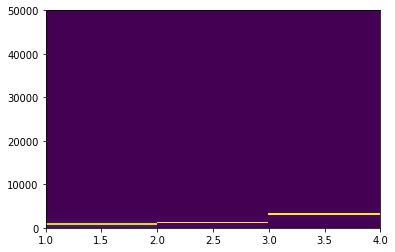

In [10]:
W = np.zeros((v1.shape[0],3))
W[:,0] = v1
W[:,1] = v2
W[:,2] = v3

print(W.shape)

plt.pcolormesh([1,2,3,4],f,W)
plt.show()

Enfin, nous calculons la matrice de coût, à partir des fréquences.

In [11]:
C = frequential_cost_matrix(f)
print(C)

[[0.00000000e+00 1.52587891e+05 6.10351562e+05 ... 2.42248535e+09
  2.46109009e+09 2.50000000e+09]
 [1.52587891e+05 0.00000000e+00 1.52587891e+05 ... 2.38418579e+09
  2.42248535e+09 2.46109009e+09]
 [6.10351562e+05 1.52587891e+05 0.00000000e+00 ... 2.34619141e+09
  2.38418579e+09 2.42248535e+09]
 ...
 [2.42248535e+09 2.38418579e+09 2.34619141e+09 ... 0.00000000e+00
  1.52587891e+05 6.10351562e+05]
 [2.46109009e+09 2.42248535e+09 2.38418579e+09 ... 1.52587891e+05
  0.00000000e+00 1.52587891e+05]
 [2.50000000e+09 2.46109009e+09 2.42248535e+09 ... 6.10351562e+05
  1.52587891e+05 0.00000000e+00]]


Nous employons enfin notre solveur.

In [12]:
h = compute_NMF(v,C,W)

Failure:  The algorithm terminated successfully and determined that the problem is unbounded.


Il nous reste à observer si le découpage est valide.

In [13]:
print(h)

[0.11851017 0.11977297 0.1236769 ]


In [14]:
V_ = np.dot(W, np.array(coefficients))
print(V_)
normalized_v = v/np.sum(v)
print(normalized_v)
clean_v = np.array([x if x>0.05 else 0 for x in normalized_v ])
print(clean_v)

[9.16017855e-03 1.80671401e-02 1.50553842e-01 4.60118520e-01
 1.35769783e-02 1.13814670e-02 9.55901282e-03 8.24985110e-03
 3.03489970e-01 6.00489277e-03 4.52264635e-03 2.92478414e-03
 1.54989091e-03 6.31834756e-04 1.75310458e-04 2.32560581e-05
 5.95141152e-07 4.08506807e-06 3.50363761e-06 8.92094865e-07
 1.12560801e-07 4.00375871e-07 3.83409913e-07 1.18464940e-07
 3.13713799e-08 8.18831269e-08 7.83705062e-08 2.71437210e-08
 1.10969464e-08 2.41154175e-08 2.25794714e-08 8.55256626e-09
 4.61362056e-09 8.86600622e-09 8.10919700e-09 3.32065153e-09
 2.15559269e-09 3.78957693e-09 3.39768210e-09 1.49197133e-09
 1.09997328e-09 1.80729985e-09 1.59525294e-09 7.45758497e-10
 6.01290942e-10 9.36873259e-10 8.17314757e-10 4.03990713e-10
 3.47283877e-10 5.18550027e-10 4.48559876e-10 2.32912159e-10
 2.09763987e-10 3.02544270e-10 2.60172625e-10 1.41050343e-10
 1.31459598e-10 1.84289235e-10 1.57864071e-10 8.88523345e-11
 8.49438279e-11 1.16326344e-10 9.94098190e-11 5.77812982e-11
 5.62978517e-11 7.563363

In [68]:
M = 4
v = np.zeros((M,))

v[1] = 1/6
v[2] = 3/6
v[0] = 2/6

W = np.zeros((M,3))
W[1,0] = 1
#W[0,1] = 1/3
#W[1,1] = 1/3
#W[2,1] = 1/3
W[2,1] = 1
W[0,2] = 0.5
W[3,2] = 0.5

C = np.ones((M,M))
for i in range(M):
    for j in range(M):
        C[i,j] = (i-j)**2
    
c,A,b = simplex_OT_canonical_matrices(v,W,C)
print(c)
print(A)
print(b)
print("-----")
print(W)

h = compute_NMF(v,C,W)
print(h)
print(v)
print(np.dot(W,h))

th = simplex_algorithm(c, A, b)
print(th)

[0. 1. 4. 9. 1. 0. 1. 4. 4. 1. 0. 1. 9. 4. 1. 0. 0. 0. 0.]
[[ 1.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   1.   1.   1.   1.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   1.   1.   0.   0.
   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.
   1.   1.   0.   0.   0. ]
 [ 1.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   1.   0.
   0.   0.  -0.  -0.  -0.5]
 [ 0.   1.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   1.
   0.   0.  -1.  -0.  -0. ]
 [ 0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.
   1.   0.  -0.  -1.  -0. ]
 [ 0.   0.   0.   1.   0.   0.   0.   1.   0.   0.   0.   1.   0.   0.
   0.   1.  -0.  -0.  -0.5]]
[0.33333333 0.16666667 0.5        0.         0.         0.
 0.         0.        ]
-----
[[0.  0.  0.5]
 [1.  0.  0. ]
 [0.  1.  0. ]
 [0.  0.  0.5]